Train validation data with convnet

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
%load_ext autoreload
    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')

In [81]:
data['train_len'] = data['ptl_occ'] / data['ptl_freq']
data.head()

In [83]:
test_data = data[data['ptl_idx']==1]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


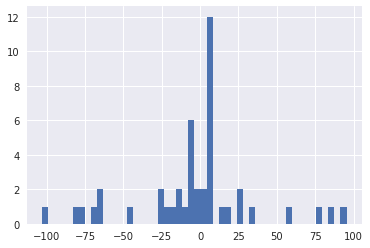

In [84]:
test_data['dt1'].hist(bins=50)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


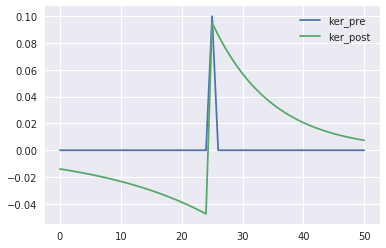

In [85]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen(scale_left=0.05, scale_right=0.1, tau_left=40, tau_right=20, scale=0.1)
plt.plot(ker_test.dot_ker, label='ker_pre')
plt.plot(ker_test.bilat_ker, label='ker_post')
plt.legend()

In [86]:
# # Combine the 3 training sets and targets to generate the new training and targets

# input_3_ptl = []
# target_3_ptl = []

# # input_stdp =np.load('/data/STDP_toy_input.npy')
# # input_3_ptl.append(input_stdp)
# # target_stdp = np.load('/data/STDP_toy_target.npy')
# # target_3_ptl.append(target_stdp)
# input_triplet = np.load('/data/Triplet_toy_input.npy')
# input_3_ptl.append(input_triplet)
# target_triplet = np.load('/data/Triplet_toy_target.npy')
# target_3_ptl.append(target_triplet)
# input_quad = np.load('/data/Quad_toy_input.npy')
# input_3_ptl.append(input_quad)
# target_quad = np.load('/data/Quad_toy_target.npy')
# target_3_ptl.append(target_quad)

# spk_pairs = np.vstack(input_3_ptl)
# # targets = np.vstack(target_3_ptl)

In [87]:
# Generate data
ptl_list = [2,3,4]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=10)
# spk_pairs, targets = arb_w_gen(spk_pairs=spk_pairs, kernel=ker_test)

In [88]:
# Create the network
ground_truth_init = 0
toy_data_net = network.PairNet(kernel=ker_test, kernel_pre=ker_test.dot_ker, kernel_post=ker_test.bilat_ker, ground_truth_init=ground_truth_init, n_input=spk_pairs.shape[1])

In [89]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/PairNet_ptl2-4_toy_old'
toy_net_trainer = trainer.Trainer(toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [90]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train, X_vali, y_train, y_vali = train_test_split(spk_pairs, targets, test_size=0.1)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

0.0

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


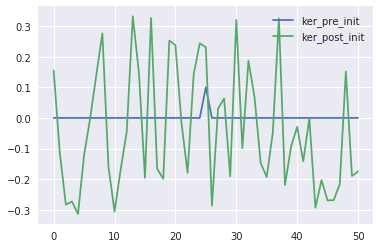

In [91]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
plt.plot(w_pre, label='ker_pre_init')
plt.plot(w_post, label='ker_post_init')
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.legend()
bias

In [95]:
# Learn the kernel from random initialization
learning_rate = 0.0001
iterations = 3
min_error = 0.000001
for i in range(iterations):
    toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
    learning_rate = learning_rate/3

Global Step 6550 and Step 0025: validation cost=0.00181
Updated min validation loss!Saving model...
Global Step 6600 and Step 0075: validation cost=0.00178
Updated min validation loss!Saving model...
Global Step 6650 and Step 0125: validation cost=0.00174
Updated min validation loss!Saving model...
Global Step 6700 and Step 0175: validation cost=0.00170
Updated min validation loss!Saving model...
Global Step 6750 and Step 0225: validation cost=0.00167
Updated min validation loss!Saving model...
Global Step 6800 and Step 0275: validation cost=0.00164
Updated min validation loss!Saving model...
Global Step 6850 and Step 0325: validation cost=0.00160
Updated min validation loss!Saving model...
Global Step 6900 and Step 0375: validation cost=0.00156
Updated min validation loss!Saving model...
Global Step 6950 and Step 0425: validation cost=0.00153
Updated min validation loss!Saving model...
Global Step 7000 and Step 0475: validation cost=0.00150
Updated min validation loss!Saving model...


bias = -0.00029880361398682


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


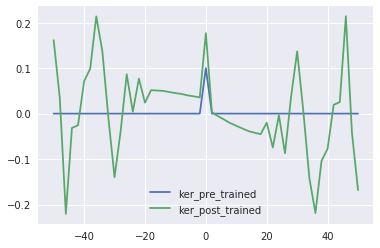

In [96]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
plt.plot(np.linspace(0,50,51)*2 - 50, w_pre,  label='ker_pre_trained')
plt.plot(np.linspace(0,50,51)*2 - 50, w_post,  label='ker_post_trained')
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.legend()
print("bias = {bias}".format(bias=bias))